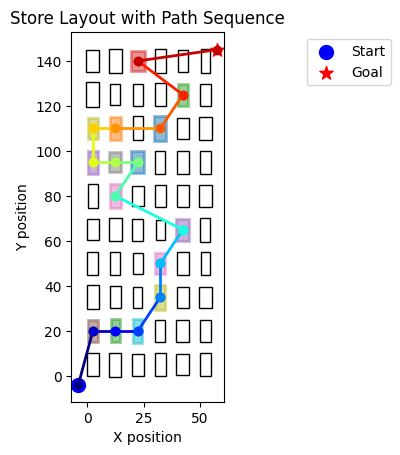

In [1]:
import numpy as np
from scipy.spatial import distance
from store import Store
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from ortools.constraint_solver import routing_enums_pb2, pywrapcp
from typing import List, Tuple, Optional, Any
from shelf import Shelf


def compute_euclidean_distance_matrix(locations: np.ndarray) -> np.ndarray:
    return distance.cdist(locations, locations, "euclidean").astype(int)


def plot_store(store: Store, random_shelves: List[Shelf], path: np.ndarray) -> None:
    fig, ax = plt.subplots()
    tab20 = plt.get_cmap("tab20")
    tab10 = plt.get_cmap("tab10")
    jet = plt.get_cmap("jet")

    all_shelves_coords = np.array(
        [
            (shelf.cx, shelf.cy)
            for row in store.shelves
            for shelf in row
            if shelf is not None
        ]
    )

    for i, row in enumerate(store.shelves):
        for shelf in row:
            if shelf:
                color = "black"
                fill = "none"
                linewidth = 1
                alpha = 1

                if shelf in random_shelves:
                    color_index = random_shelves.index(shelf)
                    color = tab10(color_index / len(random_shelves))
                    fill = color
                    linewidth = 2
                    alpha = 0.5

                rect = patches.Rectangle(
                    (shelf.cx - shelf.width / 2, shelf.cy - shelf.length / 2),
                    shelf.width,
                    shelf.length,
                    linewidth=linewidth,
                    edgecolor=color,
                    facecolor=fill,
                    alpha=alpha,
                )
                ax.add_patch(rect)

    for i in range(len(path) - 1):
        start, end = path[i], path[i + 1]
        ax.plot(
            [start[0], end[0]],
            [start[1], end[1]],
            "o-",
            color=jet(i / (len(path) - 1)),
            linewidth=2,
        )

    start_point = path[0]
    goal_point = path[-1]
    ax.scatter(
        start_point[0], start_point[1], color="blue", s=100, marker="o", label="Start"
    )
    ax.scatter(
        goal_point[0], goal_point[1], color="red", s=100, marker="*", label="Goal"
    )

    ax.set_xlabel("X position")
    ax.set_ylabel("Y position")
    ax.set_title("Store Layout with Path Sequence")
    ax.set_aspect("equal")
    ax.legend(loc="upper left", bbox_to_anchor=(1.5, 1))
    plt.show()


def setup_routing_and_solve(data: dict) -> Optional[np.ndarray]:
    manager = pywrapcp.RoutingIndexManager(
        len(data["locations"]), data["num_vehicles"], data["depot"]
    )
    routing = pywrapcp.RoutingModel(manager)
    distance_matrix = compute_euclidean_distance_matrix(data["locations"])

    transit_callback_index = routing.RegisterTransitCallback(
        lambda from_index, to_index: distance_matrix[manager.IndexToNode(from_index)][
            manager.IndexToNode(to_index)
        ]
    )
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)
    routing.solver().Add(
        routing.NextVar(manager.NodeToIndex(len(data["locations"]) - 1))
        == routing.End(0)
    )

    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.local_search_metaheuristic = (
        routing_enums_pb2.LocalSearchMetaheuristic.AUTOMATIC
    )
    search_parameters.time_limit.seconds = 5
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.AUTOMATIC
    )
    search_parameters.log_search = True

    solution = routing.SolveWithParameters(search_parameters)
    if solution:
        return extract_path(manager, routing, solution, data["locations"])
    else:
        print("No solution found!")
        return None


def extract_path(
    manager: pywrapcp.RoutingIndexManager,
    routing: pywrapcp.RoutingModel,
    solution: pywrapcp.Assignment,
    locations: np.ndarray,
) -> np.ndarray:
    index = routing.Start(0)
    path = []
    while not routing.IsEnd(index):
        path.append(locations[manager.IndexToNode(index)])
        index = solution.Value(routing.NextVar(index))
    path.append(locations[manager.IndexToNode(index)])  # add the last point
    return np.array(path)[:-1]


def print_solution(path: np.ndarray, solution: pywrapcp.Assignment) -> None:
    print(f"Objective: {solution.ObjectiveValue()}")
    route = " -> ".join(str(int(p)) for p in path)
    print(f"Route: {route}")


if __name__ == "__main__":
    k: int = 100

    store: Store = Store(10, 6)
    start_location: np.ndarray = np.array([-4, -4])
    random_shelves = store.get_random_shelves(15)
    selected_shelves_info: List[Tuple[str, Tuple[float, float]]] = [
        (shelf.position, (shelf.cx, shelf.cy))
        for shelf in random_shelves
        if shelf is not None
    ]
    all_shelves_info: List[Tuple[str, Tuple[float, float]]] = [
        (shelf.position, (shelf.cx, shelf.cy))
        for row in store.shelves
        for shelf in row
        if shelf is not None
    ]

    all_shelf_coords: np.ndarray = np.array(
        [
            (shelf.cx, shelf.cy)
            for row in store.shelves
            for shelf in row
            if shelf is not None
        ]
    )
    furthest_shelf_index: int = int(
        np.argmax(
            distance.cdist([start_location], all_shelf_coords, "euclidean").flatten()
        )
    )
    furthest_shelf: Tuple[float, float] = all_shelf_coords[furthest_shelf_index]
    goal_location: Tuple[float, float] = (furthest_shelf[0] + 5, furthest_shelf[1] + 5)
    selected_shelves_coords: np.ndarray = np.array(
        [start_location]
        + [coords for _, coords in selected_shelves_info]
        + [goal_location]
    )
    locations: np.ndarray = selected_shelves_coords * k
    data: dict = {"locations": locations, "num_vehicles": 1, "depot": 0}
    path: Optional[np.ndarray] = setup_routing_and_solve(data)
    if path is not None:
        plot_store(
            store, random_shelves, path / 100  # Rescale coordinates for plotting
        )
